In [1]:
# Je regroupe les imports en début de notebook
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb # installation : conda install -c conda-forge xgboost

# Je me positionne dans mon répertoire de travail personnel
os.chdir("C:\\Users\\Julien Gremillot\\OneDrive\\Documents\\OpenClassrooms\\Jupyter")
os.getcwd()

# Lecture du fichier CSV
data = pd.read_csv("building-energy-model-data.csv", sep=',') # séparateur = virgule

In [2]:
print(data.columns.tolist())

['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Latitude', 'Longitude', 'age', 'consommation', 'emissions', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '0.1', '1.1', '2.1', '3.1', '0.2', '1.2', '2.2', '3.2', '4.1', '5.1', '6.1', '7.1', '8.1', '9.1', '10.1', '11.1', '12.1', '13.1', '14.1', '15.1', '16.1', '17.1', '18.1', '19.1', '20.1', '0.3', '1.3', '2.3', '3.3', '4.2', '5.2', '6.2', '7.2', '8.2', '9.2', '10.2', '11.2', '0.4', '1.4', '2.4']


In [3]:
index_consommation = -1
index_emissions = -1
for i in range(len(data.columns)):
    if data.iloc[:, i].name == 'consommation':
        index_consommation = i
    if data.iloc[:, i].name == 'emissions':
        index_emissions = i
print('index_consommation =', index_consommation, '\nindex_emissions =', index_emissions)

index_consommation = 11 
index_emissions = 12


In [4]:
# On récupère les features d'un côté...
X = pd.concat([data.iloc[:,:index_consommation], data.iloc[:,index_emissions+1:]], axis = 1)

# et les targets de l'autre
y_consommation = data.iloc[:,index_consommation]
y_emissions = data.iloc[:,index_emissions]

print("Données initiales :", data.shape)
print("Features :", X.shape)
print("Targets :", y_consommation.shape, "&", y_emissions.shape)
print(X.columns.tolist(), "\n", y_consommation.head(), "\n", y_emissions.head())

Données initiales : (1687, 117)
Features : (1687, 115)
Targets : (1687,) & (1687,)
['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Latitude', 'Longitude', 'age', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '0.1', '1.1', '2.1', '3.1', '0.2', '1.2', '2.2', '3.2', '4.1', '5.1', '6.1', '7.1', '8.1', '9.1', '10.1', '11.1', '12.1', '13.1', '14.1', '15.1', '16.1', '17.1', '18.1', '19.1', '20.1', '0.3', '1.3', '2.3', '3.3', '4.2', '5.2', '6.2', '7.2', '8.2', '9.2', '10.2', '11.2', '0.4', '1.4', '2.4'] 
 0    16.107916
1 

On commence par définir nos jeux de données pour le modèle de prédiction de la consommation d'énergie (y_consommation) et on standardise les données.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_consommation, test_size=0.2)
ct = ColumnTransformer([
        ('transformer_categ_columns', StandardScaler(), 
           ['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 
            'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 
            'ENERGYSTARScore', 'Latitude', 'Longitude', 'age'])
    ], remainder='passthrough').fit(X_train)

X_train_std = ct.transform(X_train)
X_test_std = ct.transform(X_test)

In [6]:
X_train

,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,Latitude,Longitude,...,5.2,6.2,7.2,8.2,9.2,10.2,11.2,0.4,1.4,2.4
101,7,1.0,1.0,0,60696,0.0,0.0,73.0,47.62395,-122.35077,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1281,1,1.0,1.0,0,40265,0.0,0.0,19.0,47.52254,-122.36627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1103,5,1.0,1.0,0,30160,0.0,0.0,73.0,47.72083,-122.29979,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1097,3,1.0,1.0,0,274568,135954.0,0.0,52.0,47.60862,-122.32372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
734,6,1.0,2.0,0,23931,0.0,0.0,88.0,47.67572,-122.32850,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,1,1.0,1.0,0,22000,0.0,0.0,14.0,47.51918,-122.31957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1376,7,1.0,4.0,0,39030,6685.0,0.0,99.0,47.59979,-122.33318,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,6,4.0,5.0,0,285333,148865.0,0.0,14.0,47.66737,-122.37956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
724,4,1.0,2.0,0,20384,0.0,0.0,16.0,47.66461,-122.30142,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
X_train_std

array([[ 1.18369832, -0.06635024, -0.53338632, ...,  0.        ,
         0.        ,  0.        ],
       [-1.53581749, -0.06635024, -0.53338632, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.27719305, -0.06635024, -0.53338632, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.73044568,  0.86600886,  0.16181962, ...,  0.        ,
         0.        ,  0.        ],
       [-0.17605959, -0.06635024, -0.35958483, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18369832, -0.06635024,  0.68322407, ...,  0.        ,
         0.        ,  0.        ]])

Ici on définit une première fonction qui va nous afficher les différentes mesures de qualité d'après les prédictions de nos modèles et une seconde fonction qui va entrainer le modèle du type passé en paramètre, faire des prédictions et appeler la première méthode pour afficher les résultats de ce modèle.

In [8]:
mean_absolute_errors = {}
mean_squared_errors = {}
root_mean_squared_errors = {}
rmpses = {}
mean_absolute_percentage_errors = {}
r2_scores = {}
fit_times = {}
predict_times = {}

def fit_predict_and_show_metrics(model, Xtrain, Xtest, ytrain, ytest, model_name):
    """
    Réalise l'entrainement du modèle et la prédiction sur les données de test,
    puis calcule les métriques d'évaluation
    """
    tps1 = time.time()
    model.fit(Xtrain, ytrain)
    tps2 = time.time()
    ypred = model.predict(Xtest)
    fit_times[model_name] = tps2 - tps1
    predict_times[model_name] = time.time() - tps2
    mean_absolute_errors[model_name] = mean_absolute_error(ytest, ypred)
    mean_squared_errors[model_name] = mean_squared_error(ytest, ypred)
    root_mean_squared_errors[model_name] = np.sqrt(mean_squared_errors[model_name])
    rmpses[model_name] = np.sqrt(np.mean(np.square(((ytest - ypred) / ytest))))
    mean_absolute_percentage_errors[model_name] = mean_absolute_percentage_error(ytest, ypred)
    r2_scores[model_name] = r2_score(ytest, ypred)
    print("mean_absolute_error : {:.2f}".format(mean_absolute_errors[model_name]))
    print("mean_squared_error : {:.2f}".format(mean_squared_errors[model_name]))
    print("root_mean_squared_error : {:.2f}".format(root_mean_squared_errors[model_name]))
    print("rmpse : {:.2f}".format(rmpses[model_name]))
    print("mean_absolute_percentage_error : {:.2f}".format(mean_absolute_percentage_errors[model_name]))
    print("r2_score : {:.2f}".format(r2_scores[model_name]))

On commence par entrainer un modèle "Dummy" (qui renvoie toujours la médiane) afin d'avoir une base de comparaison des autres résultats

In [9]:
dummy_regressor = DummyRegressor(strategy="median")
fit_predict_and_show_metrics(dummy_regressor, X_train_std, X_test_std, y_train, y_test, 'DummyRegressor')

mean_absolute_error : 1.02
mean_squared_error : 1.80
root_mean_squared_error : 1.34
rmpse : 0.09
mean_absolute_percentage_error : 0.07
r2_score : -0.00


Puis on affiche les scores pour un modèle de régression linéaire et ses dérivées Ridge et Lasso :

In [10]:
linear_regression = LinearRegression()   
fit_predict_and_show_metrics(linear_regression, X_train, X_test, y_train, y_test, 'LinearRegression')

mean_absolute_error : 0.62
mean_squared_error : 0.63
root_mean_squared_error : 0.80
rmpse : 0.05
mean_absolute_percentage_error : 0.04
r2_score : 0.65


In [11]:
ridge = Ridge(random_state=123)
fit_predict_and_show_metrics(ridge, X_train_std, X_test_std, y_train, y_test, 'Ridge')

mean_absolute_error : 0.62
mean_squared_error : 0.63
root_mean_squared_error : 0.79
rmpse : 0.05
mean_absolute_percentage_error : 0.04
r2_score : 0.65


In [12]:
lasso = Lasso(random_state=123)
fit_predict_and_show_metrics(lasso, X_train_std, X_test_std, y_train, y_test, 'Lasso')

mean_absolute_error : 1.04
mean_squared_error : 1.79
root_mean_squared_error : 1.34
rmpse : 0.09
mean_absolute_percentage_error : 0.07
r2_score : -0.00


Pour ces 3 modèles linéaires, on constate que les scores sont "catastrophiques" : moins bons que le modèle Dummy utilisé comme référence.

On va donc tester 3 autres types de modèles non-linéaires : le Gradient, le Random Forest et le Gradient Boosting.

In [13]:
gradient_boosting_regressor = GradientBoostingRegressor(random_state=123)
fit_predict_and_show_metrics(gradient_boosting_regressor, X_train, X_test, y_train, y_test, 'GradientBoostingRegressor')
print("---")
random_forest_regressor = RandomForestRegressor(random_state=123)
fit_predict_and_show_metrics(random_forest_regressor, X_train, X_test, y_train, y_test, 'RandomForestRegressor')
print("---")
xgb_regressor = xgb.XGBRegressor(random_state=123)
fit_predict_and_show_metrics(xgb_regressor, X_train, X_test, y_train, y_test, 'XGBRegressor')

mean_absolute_error : 0.44
mean_squared_error : 0.39
root_mean_squared_error : 0.62
rmpse : 0.04
mean_absolute_percentage_error : 0.03
r2_score : 0.78
---
mean_absolute_error : 0.47
mean_squared_error : 0.46
root_mean_squared_error : 0.68
rmpse : 0.05
mean_absolute_percentage_error : 0.03
r2_score : 0.74
---
mean_absolute_error : 0.47
mean_squared_error : 0.42
root_mean_squared_error : 0.65
rmpse : 0.04
mean_absolute_percentage_error : 0.03
r2_score : 0.76


C:\anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [14]:
gradient_boosting_regressor.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 123,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

D'après les chiffres obtenus, le modèle du Gradient est le plus performant avec un score R2 de 92%.
Nous allons donc essayer d'afiner ce résultat en modifiant ses paramètres.

In [15]:
def show_best_params_cv(estimator, parameters, X_train, y_train):
    tps1 = time.time()
    print("Nombre de combinaisons de paramètres étudiées :", len(ParameterGrid(parameters)))
    grid_search_cv = GridSearchCV(estimator = estimator, param_grid = parameters, cv = 3, n_jobs=-1)
    grid_search_cv.fit(X_train, y_train)
    print("best estimator :", grid_search_cv.best_estimator_)
    print("best score :", grid_search_cv.best_score_)
    print("best params :", grid_search_cv.best_params_)
    tps2 = time.time()
    print("\nTemps de traitement total :", tps2 - tps1, "secondes")
    
gradient_boosting_regressor_parameters = {
    'learning_rate': [ 0.01, 0.1, 0.2, 0.5 ],
    'subsample'    : [ 0.1, 0.5, 1, 2 ],
    'n_estimators' : [ 50, 100, 500 ],
    'max_depth'    : [ 2, 3, 5, 10 ]
}
show_best_params_cv(GradientBoostingRegressor(random_state=123), gradient_boosting_regressor_parameters, X_train, y_train)

Nombre de combinaisons de paramètres étudiées : 192


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [ 3.32307526e-01  3.36811371e-01  3.30599784e-01             nan
  4.84292574e-01  4.81008817e-01  4.72467387e-01             nan
  7.09470241e-01  7.08476959e-01  6.91927937e-01             nan
  3.59667638e-01  3.69708824e-01  3.59031713e-01             nan
  5.22379951e-01  5.29541443e-01  5.17269450e-01             nan
  7.34628299e-01  7.45078861e-01  7.29697650e-01             nan
  3.89702234e-01  4.13741052e-01  4.04577182e-01             nan
  5.62002045e-01  5.87380554e-01  5.81512048e-01             nan
  7.49628206e-01  7.68927884e-01  7.56239080e-01             nan
  4.04377953e-01  4.44309678e-01  4.51161699e-01             nan
  5.83673143e-01  6.22481625e-01  6.17436834e-01             nan
  7.59329321e-01  7.63542506e-01  7.30337040e-01             nan
  6.86597069e-01  7.08639565e-01  6.95390121e-01             nan
  7.07550143e-01  7.51781

best estimator : GradientBoostingRegressor(max_depth=2, n_estimators=500, random_state=123,
                          subsample=1)
best score : 0.7694194568220477
best params : {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500, 'subsample': 1}

Temps de traitement total : 74.29287242889404 secondes


On ré-exécute le Gradient avec les meilleurs paramètres trouvés sur le jeu de test afin de vérifier son score via la méthode précédente.

In [16]:
gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500,
                          random_state=123, subsample=0.5)
fit_predict_and_show_metrics(gradient_boosting_regressor, X_train, X_test, y_train, y_test, 'GradientBoostingRegressor')

mean_absolute_error : 0.44
mean_squared_error : 0.38
root_mean_squared_error : 0.62
rmpse : 0.04
mean_absolute_percentage_error : 0.03
r2_score : 0.79


On essaie d'affiner les résultats du Random Forest, pour voir s'il dépasse le Gradient avec des meilleurs paramètres.

In [17]:
random_forest_regressor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [18]:
random_forest_parameters = {
    'bootstrap': [True, False],
    'max_depth': [None, 50, 60, 80],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [100, 200, 500]
}
show_best_params_cv(RandomForestRegressor(random_state=123), random_forest_parameters, X_train, y_train)

Nombre de combinaisons de paramètres étudiées : 216


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.73247787 0.73239462 0.73120899
 0.73251662 0.73284863 0.73184464        nan        nan        nan
 0.72544311 0.72447151 0.72416281 0.72544311 0.72447151 0.72416281
        nan        nan        nan 0.71272585 0.71241165 0.71138521
 0.71272585 0.71241165 0.71138521        nan        nan        nan
 0.73247787 0.73239462 0.73120899 0.73251662 0.73284863 0.73184464
        nan        nan        nan 0.72544311 0.72447151 0.72416281
 0.72544311 0.72447151 0.72416281        nan        nan        nan
 0.71272585 0.71241165 0.71138521 0.71272585 0.71241165 0.71138521
        nan        nan        nan 0.73247787 0.73239462 0.73120899
 0.73251662 0.73284863 0.73184464        nan        nan        nan
 0.72544311 0.72447151 0.72416281 0.72544311 0.72447151 0.72416281
        nan        nan        nan 0.71272585 0.71241165 0.71138521

best estimator : RandomForestRegressor(min_samples_split=3, n_estimators=200, random_state=123)
best score : 0.7328486321334508
best params : {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}

Temps de traitement total : 331.37966561317444 secondes


In [19]:
random_forest_regressor = RandomForestRegressor(n_estimators=500, random_state=123)
fit_predict_and_show_metrics(random_forest_regressor, X_train, X_test, y_train, y_test, 'RandomForestRegressor')

mean_absolute_error : 0.47
mean_squared_error : 0.47
root_mean_squared_error : 0.68
rmpse : 0.05
mean_absolute_percentage_error : 0.03
r2_score : 0.74


In [20]:
xgb_regressor.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 123,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [21]:
xgb_regressor_parameters = {
    'gamma':[ 0, 0.5, 1 ],
    'learning_rate': [ .05, .1, .3 ],
    'max_depth': [ 2, 6, 10 ],
    'min_child_weight': [ 1, 5, 10 ],
    'subsample': [ 0.5, 1, 2 ],
    'colsample_bytree': [ 0.5, 1, 2 ],
    'n_estimators': [ 50, 100, 200 ]
}
show_best_params_cv(xgb.XGBRegressor(random_state=123), xgb_regressor_parameters, X_train, y_train)

Nombre de combinaisons de paramètres étudiées : 2187


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.16240707 -0.14954814         nan ...         nan         nan
         nan]
  warnings.warn(


best estimator : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)
best score : 0.7777017619657568
best params : {'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.5}

Temps de traitement total : 1017.7536821365356 secondes


In [22]:
xgb_regressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=5, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

fit_predict_and_show_metrics(xgb_regressor, X_train, X_test, y_train, y_test, 'XGBRegressor')

mean_absolute_error : 0.43
mean_squared_error : 0.37
root_mean_squared_error : 0.61
rmpse : 0.04
mean_absolute_percentage_error : 0.03
r2_score : 0.79


C:\anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Comparaison des scores obtenus pour chaque modèle

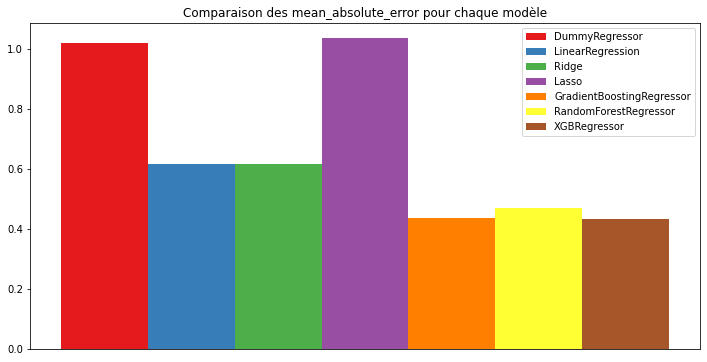

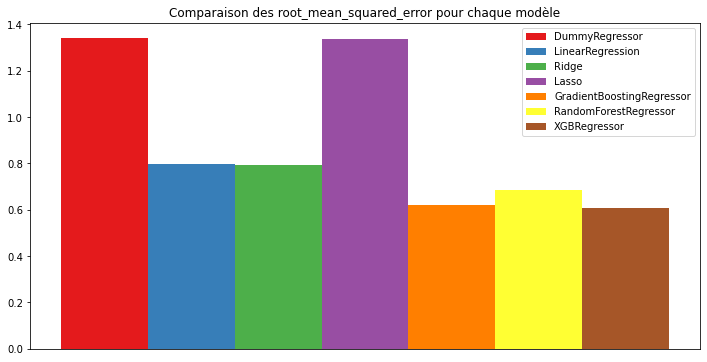

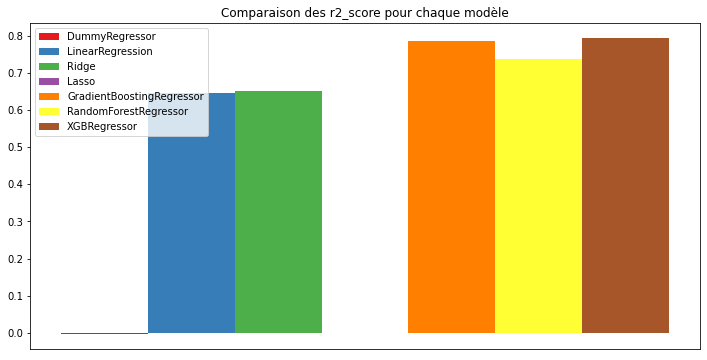

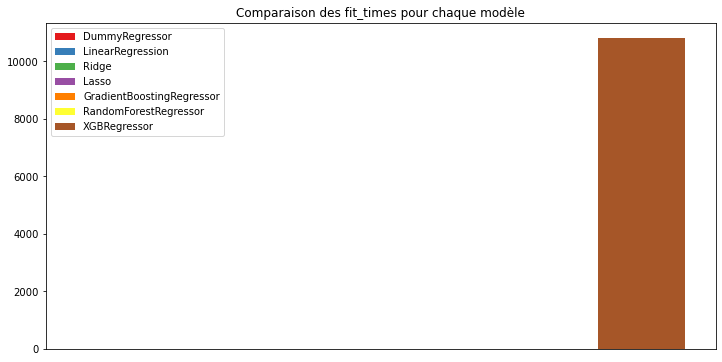

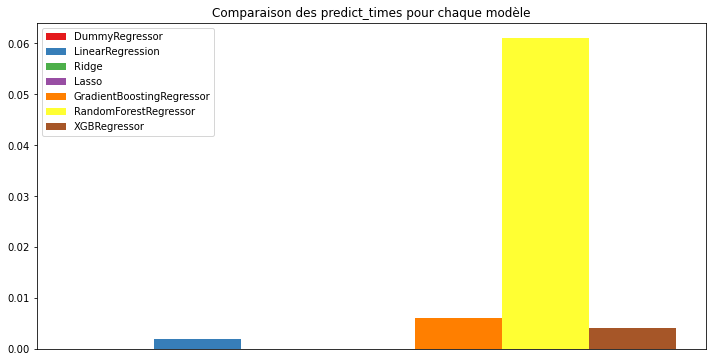

In [23]:
metrics = {
    'mean_absolute_error': mean_absolute_errors,
    'root_mean_squared_error': root_mean_squared_errors,
    'r2_score': r2_scores,
    'fit_times': fit_times,
    'predict_times': predict_times
}
width = 20
x = width * 5
for metric in metrics.keys():
    fig, ax = plt.subplots(figsize=(12,6))
    x_decalage = x - 5*width/2
    for model_name, color in zip(metrics[metric].keys(), cm.Set1.colors):
        ax.bar(x_decalage, metrics[metric][model_name], width, label=model_name, color=color)
        x_decalage = x_decalage + width
    x = x + width * 5
    ax.set_title('Comparaison des ' + metric + ' pour chaque modèle')
    ax.axes.get_xaxis().set_visible(False)
    ax.legend()
    plt.show()


On refait maintenant l'exercice avec la seconde target : les émissions de gaz à effet de serre.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y_emissions, test_size=0.2)
ct = ColumnTransformer([
        ('transformer_categ_columns', StandardScaler(), 
           ['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 
            'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 
            'ENERGYSTARScore', 'Latitude', 'Longitude', 'age'])
    ], remainder='passthrough').fit(X_train)
X_train_std = ct.transform(X_train)
X_test_std = ct.transform(X_test)

mean_absolute_errors = {}
mean_squared_errors = {}
root_mean_squared_errors = {}
rmpses = {}
mean_absolute_percentage_errors = {}
r2_scores = {}
fit_times = {}
predict_times = {}

dummy_regressor = DummyRegressor(strategy="median")
fit_predict_and_show_metrics(dummy_regressor, X_train_std, X_test_std, y_train, y_test, 'DummyRegressor')
print("---")
linear_regression = LinearRegression()   
fit_predict_and_show_metrics(linear_regression, X_train, X_test, y_train, y_test, 'LinearRegression')
print("---")
ridge = Ridge(random_state=123)
fit_predict_and_show_metrics(ridge, X_train_std, X_test_std, y_train, y_test, 'Ridge')
print("---")
lasso = Lasso(random_state=123)
fit_predict_and_show_metrics(lasso, X_train_std, X_test_std, y_train, y_test, 'Lasso')

mean_absolute_error : 1.13
mean_squared_error : 2.17
root_mean_squared_error : 1.47
rmpse : 3.65
mean_absolute_percentage_error : 0.88
r2_score : -0.00
---
mean_absolute_error : 0.82
mean_squared_error : 1.07
root_mean_squared_error : 1.03
rmpse : 2.24
mean_absolute_percentage_error : 0.57
r2_score : 0.51
---
mean_absolute_error : 0.81
mean_squared_error : 1.04
root_mean_squared_error : 1.02
rmpse : 2.26
mean_absolute_percentage_error : 0.57
r2_score : 0.52
---
mean_absolute_error : 1.13
mean_squared_error : 2.17
root_mean_squared_error : 1.47
rmpse : 3.68
mean_absolute_percentage_error : 0.89
r2_score : -0.00


In [25]:
show_best_params_cv(GradientBoostingRegressor(random_state=123), gradient_boosting_regressor_parameters, X_train, y_train)
show_best_params_cv(RandomForestRegressor(random_state=123), random_forest_parameters, X_train, y_train)
show_best_params_cv(xgb.XGBRegressor(random_state=123), xgb_regressor_parameters, X_train, y_train)

Nombre de combinaisons de paramètres étudiées : 192


C:\anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [ 2.51679582e-01  2.61035028e-01  2.57248396e-01             nan
  3.68805871e-01  3.78798831e-01  3.69905070e-01             nan
  5.95718493e-01  5.96987605e-01  5.72314875e-01             nan
  2.87304048e-01  3.06358231e-01  3.03206106e-01             nan
  4.15590757e-01  4.39201469e-01  4.30644740e-01             nan
  6.25875960e-01  6.37693953e-01  6.13482389e-01             nan
  3.15744529e-01  3.52341365e-01  3.49867278e-01             nan
  4.58560382e-01  4.98950497e-01  4.91811285e-01             nan
  6.43150961e-01  6.60325899e-01  6.42231799e-01             nan
  3.33148207e-01  3.83653441e-01  3.78177647e-0

best estimator : GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500,
                          random_state=123, subsample=0.5)
best score : 0.6603258986715316
best params : {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.5}

Temps de traitement total : 40064.07036995888 secondes
Nombre de combinaisons de paramètres étudiées : 216


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.6233061  0.62443925 0.62473075
 0.62119979 0.6234589  0.62446308        nan        nan        nan
 0.61041887 0.61285684 0.61235981 0.61041887 0.61285684 0.61235981
        nan        nan        nan 0.59936317 0.60190808 0.60358878
 0.59936317 0.60190808 0.60358878        nan        nan        nan
 0.6233061  0.62443925 0.62473075 0.62119979 0.6234589  0.62446308
        nan        nan        nan 0.61041887 0.61285684 0.61235981
 0.61041887 0.61285684 0.61235981        nan        nan        nan
 0.59936317 0.60190808 0.60358878 0.59936317 0.60190808 0.60358878
        nan        nan        nan 0.6233061  0.62443925 0.62473075
 0.62119979 0.6234589  0.62446308        nan        nan        nan
 0.61041887 0.61285684 0.61235981 0.61041887 0.61285684 0.61235981
        nan        nan        nan 0.59936317 0.60190808 0.60358878

best estimator : RandomForestRegressor(n_estimators=500, random_state=123)
best score : 0.6247307506103736
best params : {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

Temps de traitement total : 331.90262174606323 secondes
Nombre de combinaisons de paramètres étudiées : 2187


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.46571949 0.44365215        nan ...        nan        nan        nan]
  warnings.warn(


best estimator : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)
best score : 0.671592897846988
best params : {'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.5}

Temps de traitement total : 741.2533979415894 secondes


In [28]:
gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500,
                          random_state=123, subsample=0.5)
fit_predict_and_show_metrics(gradient_boosting_regressor, X_train_std, X_test_std, y_train, y_test, 'GradientBoostingRegressor')
print("---")
random_forest_regressor = RandomForestRegressor(n_estimators=500, random_state=123)
fit_predict_and_show_metrics(random_forest_regressor, X_train_std, X_test_std, y_train, y_test, 'RandomForestRegressor')
print("---")
xgb_regressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)
fit_predict_and_show_metrics(xgb_regressor, X_train_std, X_test_std, y_train, y_test, 'XGBRegressor')

mean_absolute_error : 0.65
mean_squared_error : 0.69
root_mean_squared_error : 0.83
rmpse : 1.66
mean_absolute_percentage_error : 0.43
r2_score : 0.68
---
mean_absolute_error : 0.65
mean_squared_error : 0.71
root_mean_squared_error : 0.84
rmpse : 1.62
mean_absolute_percentage_error : 0.43
r2_score : 0.67
---
mean_absolute_error : 0.66
mean_squared_error : 0.71
root_mean_squared_error : 0.85
rmpse : 1.61
mean_absolute_percentage_error : 0.43
r2_score : 0.67


C:\anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


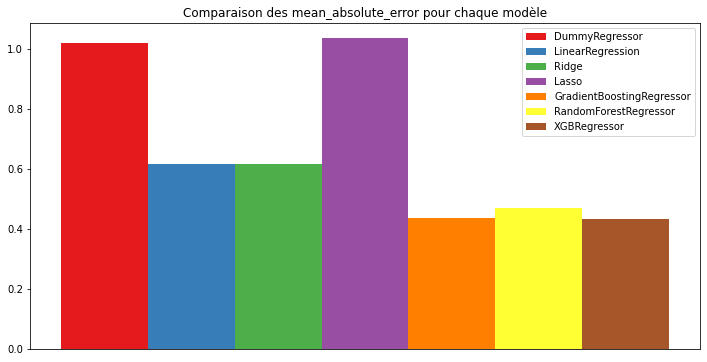

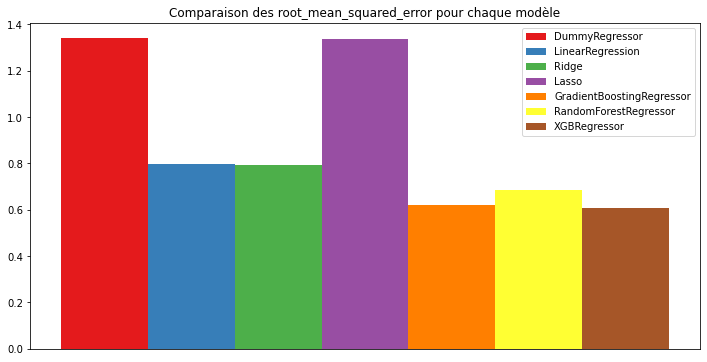

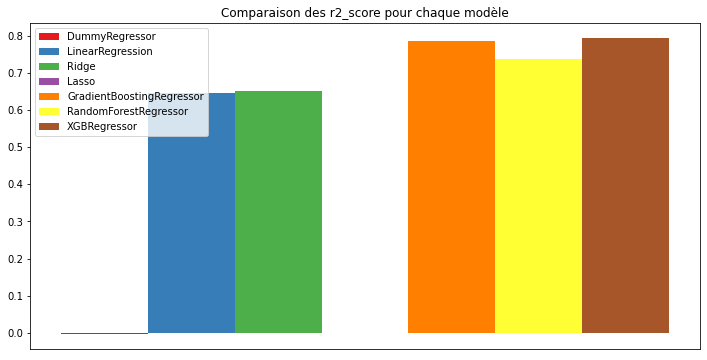

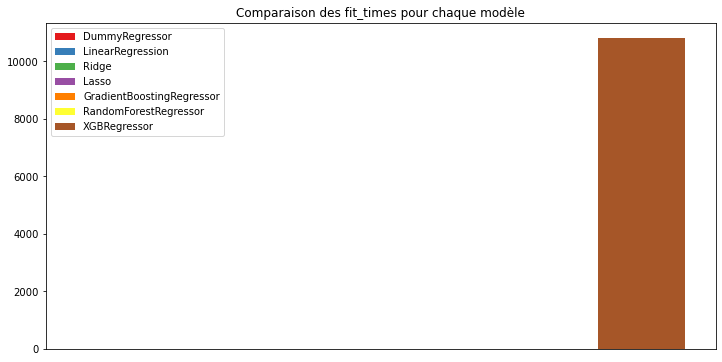

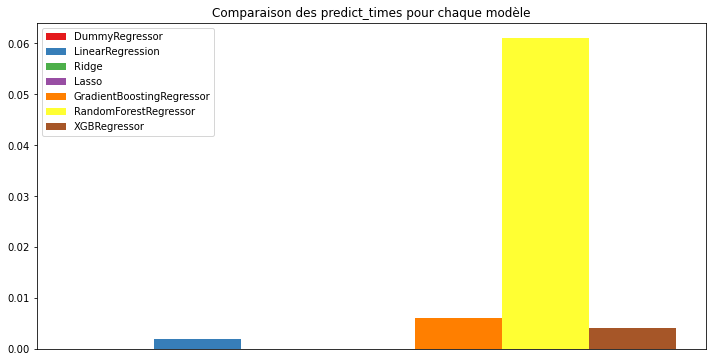

In [29]:
width = 20
x = width * 5
for metric in metrics.keys():
    fig, ax = plt.subplots(figsize=(12,6))
    x_decalage = x - 5*width/2
    for model_name, color in zip(metrics[metric].keys(), cm.Set1.colors):
        ax.bar(x_decalage, metrics[metric][model_name], width, label=model_name, color=color)
        x_decalage = x_decalage + width
    x = x + width * 5
    ax.set_title('Comparaison des ' + metric + ' pour chaque modèle')
    ax.axes.get_xaxis().set_visible(False)
    ax.legend()
    plt.show()